Check which observations are hit, say those can only have 1 snap used and thus have a 0.37 mag depth penalty

Using

* 30k Starlink v2 constellation
* 1st year of observations in r
* If a visit has a streak, give five-sigma depth a 0.37 mag penalty
* ignoring twilight NEO observations (since those are 1-snap visits anyway)


In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.satellite_constellations import (Constellation, starlink_tles_v2,
                                                ModelObservatory,
                                                SatelliteAvoidBasisFunction)
import healpy as hp
from rubin_sim.data import get_baseline
import pandas as pd
import sqlite3

In [3]:
tles = starlink_tles_v2()
const = Constellation(tles)
len(tles)

29988

In [4]:
baseline = get_baseline()
con = sqlite3.connect(baseline)
visits = pd.read_sql('select fieldRA, fieldDec, fivesigmadepth, observationstartmjd,rotSkyPos from observations where night < 365 and visitexposuretime > 20 and filter="r"', con)
con.close()

In [5]:
visits

,fieldRA,fieldDec,fiveSigmaDepth,observationStartMJD,rotSkyPos
0,356.288005,-51.164810,23.128326,60218.004914,129.375130
1,0.158759,-53.139864,23.075882,60218.005362,130.108353
2,4.323837,-51.858683,23.147026,60218.005810,134.437221
3,4.386324,-54.962388,23.149994,60218.006256,131.810738
4,4.380452,-58.068073,23.201271,60218.006702,129.126645
...,...,...,...,...,...
44392,41.038265,-3.628448,23.930048,60582.374718,250.109668
44393,45.759568,-0.586964,23.933535,60582.375179,243.746554
44394,55.829011,2.654325,23.969454,60582.375701,230.577839
44395,60.036482,-3.725642,24.076105,60582.376165,229.067558


In [6]:
keys = ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'rotSkyPos']
types = [float] * len(keys)

numpy_visits = np.zeros(np.size(visits["fieldRA"].values), dtype=list(zip(keys,types)))

for key in keys:
    numpy_visits[key] = visits[key].values



In [7]:
streak_lengths, n_streaks = const.check_pointings(visits["fieldRA"].values,
                                                         visits["fieldDec"].values,
                                                         visits["observationStartMJD"].values, visit_time=32.)

/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [8]:
n_streaks

array([1, 1, 0, ..., 0, 0, 1])

In [9]:
# let's compute the depth for the things
import rubin_sim.maf as maf

In [10]:
metric = maf.Coaddm5Metric()
slicer = maf.HealpixSlicer()
sql = None
bundle = maf.MetricBundle(metric, slicer, sql)

bd = {1: bundle}
mbg = maf.MetricBundleGroup(bd, None, "temp")
mbg.run_current(None, sim_data=numpy_visits)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


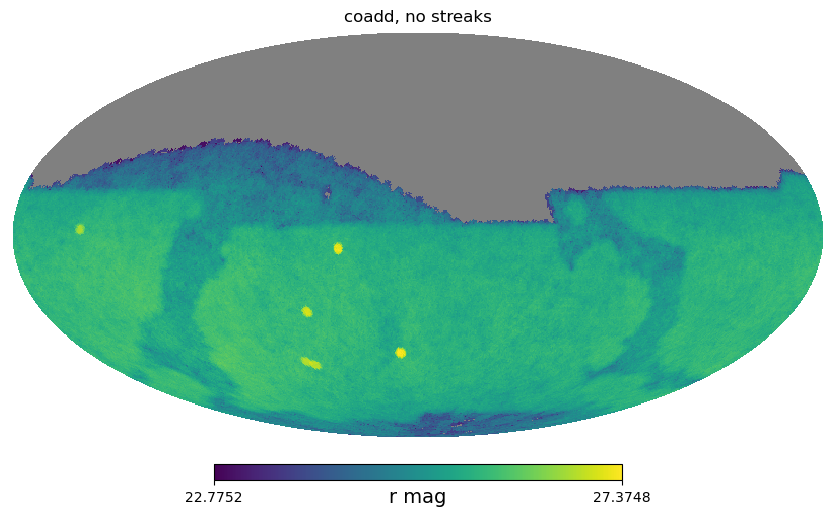

In [ ]:
hp.mollview(bundle.metric_values, unit='r mag', title='coadd, no streaks')

In [12]:
penalty = 0.37

numpy_visits_penalized = numpy_visits.copy()
numpy_visits_penalized['fiveSigmaDepth'][np.where(n_streaks > 0)] -= penalty


bundle2 = maf.MetricBundle(metric, slicer, sql)
bd = {1: bundle2}
mbg = maf.MetricBundleGroup(bd, None, "temp")
mbg.run_current(None, sim_data=numpy_visits_penalized)

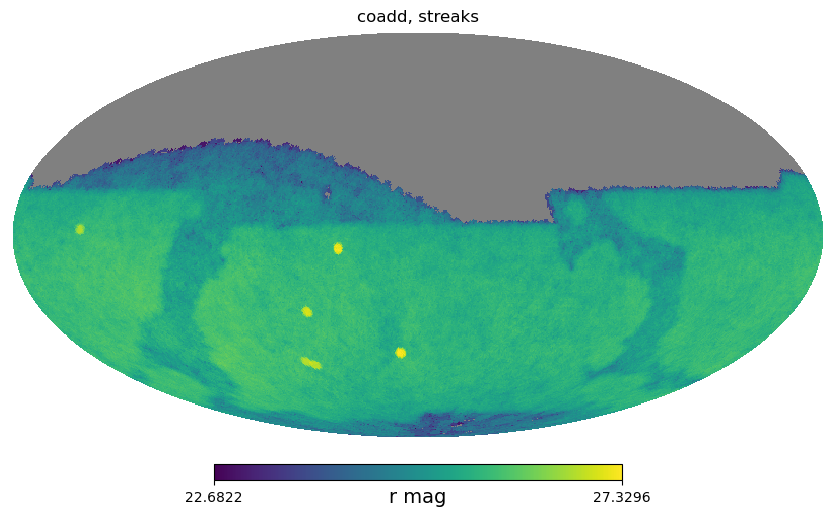

In [13]:
hp.mollview(bundle2.metric_values, unit='r mag', title='coadd, streaks')

In [ ]:
mag_diff = bundle2.metric_values - bundle.metric_values

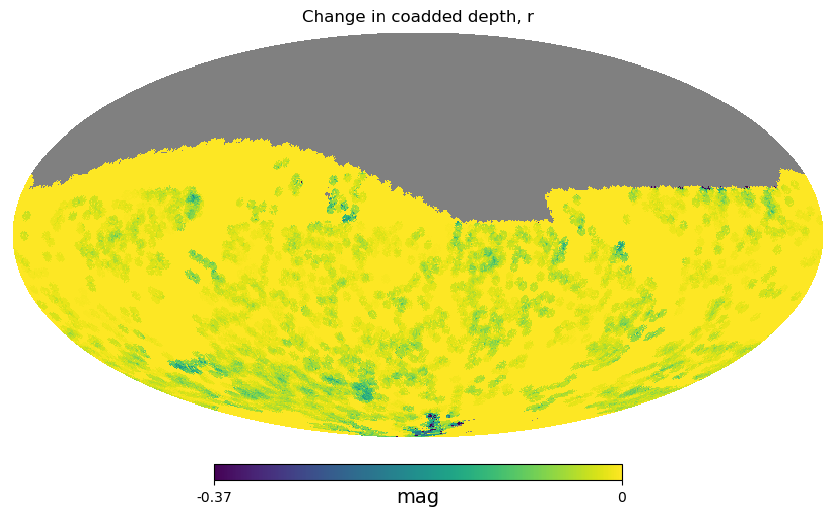

In [15]:
hp.mollview(mag_diff, title='Change in coadded depth, r', unit='mag')

Text(0, 0.5, 'N pix')

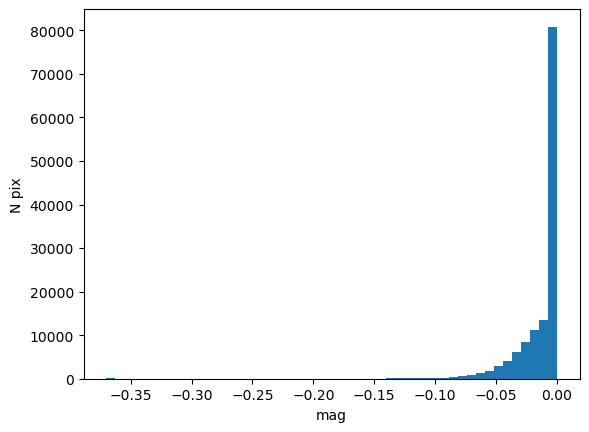

In [16]:
_temp=plt.hist(mag_diff, bins=50)
plt.xlabel('mag')
plt.ylabel('N pix')


In [17]:
print('median change in depth', np.median(mag_diff[np.isfinite(mag_diff)]), ' mags')
print('mean change in depth', np.mean(mag_diff[np.isfinite(mag_diff)]), ' mags')

median change in depth 0.0  mags
mean change in depth -0.011926652860044306  mags


/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [18]:
# save so we don't have to grind that out again
np.savez('streaks.npz', streak_lengths=streak_lengths, n_streaks=n_streaks)

In [19]:
np.median(bundle.metric_values), np.median(bundle2.metric_values)

(25.362439914864247, 25.347944990453854)